# <center> Dynamic Asset Pricing HW2 </center>

&copy; 2023 Kaiwen Zhou

# Topic: Option Pricing

In this exercise $S_{t}$ represents the price of a stock. We would like to price a down-and-out call; Given a maturity time $T$, a strike $K$ and a barrier $B$, the option pays $\left(S_{T}-K\right)_{+}$only if $S_{u} \geq B$ for all $u \in(t, T)$. The interest rate $r$ is constant, $S_{t}$ starts at $x>B$ and follows a Geometric Brownian Motion in the **risk neutral** measure:
$$
d S_{t}=r S_{t} d t+\sigma S_{t} d W_{t}
$$
The following questions will present the two main numerical approaches to price options.

In all the numerical experiments, we will take $t=0, T=1$ year, $r=0.02$ (2\% per year) and $\sigma=0.20$ (20\% per year), $x=100 \$, B=80 \$$ and $K=110 \$$.

### Setting up the stage

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as spst

In [2]:
t=0    # year
T=1    # year
r=0.02 # 2% per year
σ=0.20 # 20% per year
x=100  # $
B=80   # $
K=110  # $

## Using Monte Carlo

(a) Explain that the value of the option should be

$$
v_{t}=e^{-r(T-t)} \mathbb{E}\left[\left(S_{T}-K\right)_{+} \mathbb{1}_{S_{u} \geq B, \forall u \in(t, T)} \mid \mathcal{F}_{t}\right]
$$

where $\mathbb{E}$ is in the risk neutral measure.

**Solution:**

The payoff of this a down-and-out call option is 

$$
V(S_T) = \begin{cases}
    \left(S_{T}-K\right)_{+} & \text{ if } S_{u} \geq B, \forall u \in(t, T)\\
    0 & \text{ if } S_{u} < B, \forall u \in(t, T)
\end{cases} = \left(S_{T}-K\right)_{+} \mathbb{1}_{S_{u} \geq B, \forall u \in(t, T)} 
$$
    
Therefore, if $\mathbb{E}$ is in the risk neutral measure, by the risk-neutral pricing formula, we obtain

$$
v_{t}= \mathbb{E}\left[e^{-r(T-t)}V(S_T) \mid \mathcal{F}_{t}\right]=e^{-r(T-t)} \mathbb{E}\left[\left(S_{T}-K\right)_{+} \mathbb{1}_{S_{u} \geq B, \forall u \in(t, T)} \mid \mathcal{F}_{t}\right].
$$

(b) Using the SDE, write a program that computes one trajectory of $S_{t}$ for $t<T$; it should return a list of values $S_{0}, S_{\Delta t}, S_{2 \Delta t} \ldots, S_{T}$ for $\Delta T=\frac{T}{N}$ where $N$ is the number of points (you can choose $N=252$ for example).

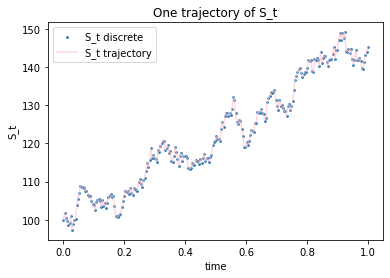

In [3]:
np.random.seed(66)  # if you want to be 'out', use seed=100
N=252 # number of discrete data points for time and S_t
time = np.linspace(0,1,N) 
δ_t = time[1]-time[0] # increment (delta) of time, 

# Generate a trajectory for S_t
S_t = [x]
for i in range(1, N):
    next_S = S_t[-1]+r*S_t[-1]*δ_t+σ*S_t[-1]*np.random.normal(0,np.sqrt(δ_t))
    S_t.append(next_S)

#PLOT
plt.scatter(time, S_t, s=3, label='S_t discrete')
plt.plot(time, S_t, alpha=0.6, c = 'pink', label='S_t trajectory')
plt.xlabel('time')
plt.ylabel('S_t')
plt.title('One trajectory of S_t')
plt.legend()

(c) Write a program that takes the list of values computed in the previous question and returns the payoff of the option $\phi(S)=\left(S_{T}-K\right)_{+}$ if all $S_{k \Delta t}>B$, and 0 otherwise.

In [4]:
def payoff(S_t, B, K):
    if np.sum(np.array(S_t) < B) > 0:
        return 0
    else:
        return np.maximum(0, S_t[-1]-K)

print('The payoff of this a down-and-out Barrier Call is: $', payoff(S_t, B, K))

The payoff of this a down-and-out Barrier Call is: $ 35.33998115070955


(d) Using your previous code, write a program that generates $N_{p}=10^{5}$ trajectories of $S$, and computes the average
$$
\frac{e^{-r(T-t)}}{N_{p}} \sum_{j=1}^{N_{p}} \phi\left(S^{(j)}\right)
$$
where $S^{(j)}$ is the $j^{t h}$ trajectory. Deduce the price of the option.

In [5]:
%%time
N_p = 100000  # number of iterations

option_values = []  # variable to hold the option value corresponding to each trajectory generated

# compute all option values
for i in range(N_p):
    S_t = [x]
    for j in range(1, N):
        next_S = S_t[-1]+r*S_t[-1]*δ_t+σ*S_t[-1]*np.random.normal(0,np.sqrt(δ_t))
        S_t.append(next_S)
    option_value_S = np.exp(-r*(T-t)) * payoff(S_t,B,K)
    option_values.append(option_value_S)

# Take the mean to find the price of the option
option_value_average = np.mean(option_values)
print(f'Using the Monte Carlo scheme with {N_p} iterations, the price of the option at t={t} is: $', option_value_average)

Using the Monte Carlo scheme with 100000 iterations, the price of the option at t=0 is: $ 4.906372599084435
CPU times: user 1min 58s, sys: 821 ms, total: 1min 59s
Wall time: 2min 1s


Moreover, we can compute the cumulative mean of option values generated from the first value to the first two values, the first three values, and so on. The key insight is that the cumulative mean of option values should converge to one value.

In [ ]:
# compute the cumulative mean from the option values generated
cumulative_mean_option_values = [np.mean(option_values[:i]) for i in range(1, N_p+1)]

Text(0.5, 1.0, 'cumulative mean of option values')

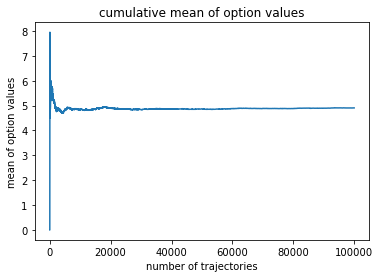

In [50]:
# PLOT the mean values against the number of trajectories
# we should see the mean converges to some value gradually
plt.plot(np.arange(N_p),cumulative_mean_option_values)  
plt.xlabel('number of trajectories')
plt.ylabel('mean of option values')
plt.title('cumulative mean of option values')

## Numerical solution of the PDE (Implicit Scheme)

1. We proved that $v(t,x)=\mathbb{E}\left[e^{-r(\tau-t)} \phi\left(S_{\tau}, \tau\right) \mid S_{t}=x\right]$ solves the PDE:
$$
\begin{cases}
 -r v(t, x)+v_{t}(t, x)+r x v_{x}(t, x)+\frac{1}{2} \sigma^{2} x^{2} v_{x x}(t, x)=0, \quad &\text { for } t<T \text { and } B<x \\
 v(T, x)=(x-K)_{+}, \quad &\text { for } B<x \\
 v(t, B)=0, \quad &\text { for } t<T
\end{cases}
$$

We will solve only for $x \in(B, R)$ for some big constant $R=300$. Let's choose $N_{x}=2200$ to be the number of points of $x$ and $N_{t}=252$ to be the number of time points.

Define $\Delta x=\frac{R-B}{N_{x}}, \Delta t=\frac{T-t}{N_{t}}, x_{k}=B+k \Delta x$ for $k=0, . ., N_{x}$ and $t_{j}=t+j \Delta t$ for $j=0, . ., N_{t}$. In the following, we will define $v\left(t_{j}, x_{k}\right)=v_{j}^{k}$ for any function $v$.
1. the final time and boundary conditions of the PDE can be numerically written as

$$
\begin{cases}
 v_{N_{t}}^{k}=\left(x_{k}-K\right)_{+}, \quad &\text { for } k=0, . ., N_{x} \\
 v_{j}^{0}=0, \quad &\text { for } j=0, . ., N_{t} \\
 v_{j}^{N_{x}}=R-e^{-r\left(T-t_{j}\right)} K, \quad &\text { for } j=0, . ., N_{t}
\end{cases}
$$
2. Define $
V_j=(
    v_{j}^0,
    v_{j}^1,
    v_{j}^2,
    \cdots,
    v_{j}^{N_x-1},
    v_{j}^{N_x}
)\in\mathbb{R}^{(N_x+1)}
$
The implicit scheme gives
$$
    v_{j}^{k}=a_k v_{j-1}^{k-1}+b_k v_{j-1}^{k}+c_k v_{j-1}^{k+1}, \text{ for all } k=1, \ldots, N_{x}-1 \text{ and } j=1, . ., N_{t}
$$
where 
$$
a_k=-\Delta t\left(-\frac{r x_{k}}{2 \Delta x}+\frac{1}{2(\Delta x)^{2}} \sigma^{2} x_{k}^{2}\right), \quad b_k=\left(1+r \Delta t+ \frac{\Delta t\sigma^{2}x_{k}^{2}}{(\Delta x)^{2}} \right), \quad c_k=-\Delta t\left(\frac{r x_{k}}{2 \Delta x}+\frac{1}{2(\Delta x)^{2}} \sigma^{2} x_{k}^{2}\right)
$$

3. We define $M$ to be
$$
M = \begin{bmatrix}
1 & 0 & 0 & 0 & \cdots & 0 & 0 & 0\\
a_1 & b_1 & c_1 & 0 & \cdots & 0 & 0 & 0\\
0 & a_2 & b_2 & c_2 & \cdots & 0 & 0 & 0\\
\vdots & \vdots & \vdots & \vdots & \cdots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & 0 & \cdots & a_{N_x-1} & b_{N_x-1} & c_{N_x-1} & \\
0 & 0 & 0 & 0 & \cdots & 0 & 0 & 1\\
\end{bmatrix}\in \mathbb{R}^{(N_x+1)\times(N_x+1)}, \quad C_{j-1} = \begin{bmatrix}
    0\\
    0\\
    0\\
    \vdots\\
    0\\
    e^{-r(T-t_j))}K- e^{-r(T-t_{j-1}))}K
\end{bmatrix} \in \mathbb{R}^{(N_x+1)}
$$

Then, we must have 
$$
V_j=MV_{j-1}-C_{j-1} \quad \Longrightarrow \quad V_{j-1}=M^{-1}(V_j+C_{j-1})
$$

In [7]:
R=300
N_x=2200
N_t=252
Δx=(R-B)/N_x
Δt=(T-t)/N_t

In [8]:
def X(k):
    return B+k*Δx

def a(k):
    return -Δt*(-r*X(k)/(2*Δx) + (σ**2 * X(k)**2)/(2 * Δx**2))

def b(k):
    return 1 + r*Δt + Δt * σ**2 * X(k)**2/(Δx**2)

def c(k):
    return -Δt*(r*X(k)/(2*Δx) + (σ**2 * X(k)**2)/(2 * Δx**2))

**Initialize the vertical boundary $v_{N_t}^k=(x_k-K)_+, \text { for } k=0, . ., N_{x}$**

In [9]:
v_N_t=np.array([np.maximum(0, X(k)-K) for k in range(N_x+1)])
v_N_t

array([  0. ,   0. ,   0. , ..., 189.8, 189.9, 190. ])

**Construct matrix $M$**

In [10]:
M=np.zeros((N_x+1,N_x+1))

# correct for the first row and the last row
M[0,0]=1
M[N_x, N_x]=1
for k in range(1,N_x):
    M[k,k-1] = a(k)
    M[k,k]=b(k)
    M[k,k+1]=c(k)
M

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.08889286e+01,  1.02841508e+02, -5.09525000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -5.10161111e+01,  1.03095952e+02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.42766738e+03, -7.13452619e+02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.13690595e+02,  1.42861929e+03, -7.13928611e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

**Begin the iteration process and account for the boundary conditions at each step.**

In [11]:
%%time
v=v_N_t
for j in range(N_t, 0, -1):
    # construct the correction matrix C_{j-1} for each iteration
    C_j_minus_1 = np.zeros(N_x+1)
    C_j_minus_1[-1] = np.exp(-r*(T-j*Δt))*K - np.exp(-r*(T-(j-1)*Δt))*K
    v=np.linalg.inv(M)@(v+C_j_minus_1)
v

CPU times: user 4min 3s, sys: 2.7 s, total: 4min 5s
Wall time: 1min 1s


array([-5.59643169e-14,  1.63666197e-02,  3.27149519e-02, ...,
        1.91978146e+02,  1.92078146e+02,  1.92178146e+02])

In [12]:
initial_price=100
print(f'The price of the option given initial price={initial_price} at time t={t} is: $',v[int((initial_price-B)/Δx)-1])

The price of the option given initial price=100 at time t=0 is: $ 4.877353434900327


## Analytical solution of the PDE

If we solved the PDE analytically instead of numerically, we would have obtained the formula:

\begin{align}
    v(t, x)=c_{K}(t, x)-\left(\frac{x}{B}\right)^{2 \alpha} c_{K}\left(t, \frac{B^2}{x}\right), \quad \alpha=\frac{1}{2}\left(1-\frac{2 r}{\sigma^{2}}\right)
\end{align}
where 
$$
C(t, x ; K, T, \sigma, r)=x N\left(d_{+}\right)-K e^{-r (T-t)} N\left(d_{-}\right)
$$

with $N(z)=\int_{-\infty}^{z} \frac{\exp \left(-y^{2} / 2\right)}{\sqrt{2 \pi}} d y$ and

$$
d_{-}=d_{+}-\sigma \sqrt{T-t}, \quad d_{+}=\frac{1}{\sigma \sqrt{T-t}}\left(\log (x / K)+\left(r+\frac{1}{2} \sigma^{2}\right) (T-t)\right)
$$

Now, we compute the price of the option given by the closed formula specified above at $t=0$.

In [37]:
def BS_eu_call(t,s_t, T, σ, K):
    d_plus = (np.log(s_t/float(K))+(r+σ**2/2)*(T-t)) / (σ*np.sqrt(T-t))
    d_minus= d_plus - σ*np.sqrt(T-t)
    return s_t*spst.norm.cdf(d_plus) - K*np.exp(-r*(T-t))*spst.norm.cdf(d_minus)

In [38]:
x,K

(100, 80)

In [39]:
%%time
α=0.5*(1-2*r/σ**2)
option_value_analytic = BS_eu_call(t,x, T, σ, K) - (x/B)**(2*α)*BS_eu_call(t,B**2/x, T, σ, K)
print(f'The the price of the option given by the closed formula at t={t} is: $', option_value_analytic)

The the price of the option given by the closed formula at t=0 is: $ 20.000000000000036
CPU times: user 774 µs, sys: 165 µs, total: 939 µs
Wall time: 810 µs


(o) Compare the prices (accuracy and speed) obtained numerically by Monte Carlo and the PDE method, with theoretical (given by the analytical solution) price from the PDE.

| |Price |Speed |Accuracy (RMSE) |
|-|-|-|-|
|Monte Carlo |4.906372599084435 |2min 1s |0.01388420913593702 |
|Finite Differece PDE |4.877353434414326 |1min 1s |0.042903373806045586 |
|THEORETICAL SOLUTION|4.920256808220372 |1.58 ms |0 |

In [40]:
# np.sqrt((4.906372599084435-4.920256808220372)**2)

# Bonus Question

In [41]:
t=0    # year
T=1    # year
σ=0.20 # 20% per year
r=0
B=80
K=80
x=100

For $r=0$, $B=K$, we must have 
$$
v(t,x)=x-B \Longleftrightarrow v(t,S_t)=S_t-B, \forall t
$$
And, in this case, $v(t,x)\equiv \$20$ at time $t$ ($=0$).

**Now, we use the analytical solution given above to verify our result.**

In [42]:
t=0
α=0.5*(1-2*r/σ**2)
option_value_analytic = BS_eu_call(t,x, T, σ, K) - (x/B)**(2*α)*BS_eu_call(t,B**2/x, T, σ, K)
print(f'The the price of the option given by the closed formula at t={t} is: $', option_value_analytic)

The the price of the option given by the closed formula at t=0 is: $ 20.000000000000036


**We can also plot the prices given by analytical solution and prices given by replicating portfolio and see if they are identical.**

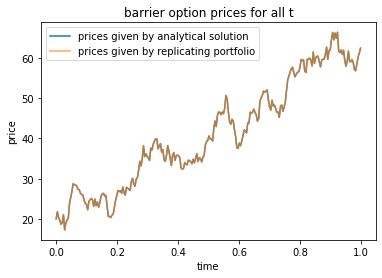

In [45]:
np.random.seed(66)
prices_analytical = []
prices_rep_portfolio=[]
time = np.linspace(0,0.999,252) # we use 0.999 to avoid the 'divide by zero' warning.
δ_t = time[1]-time[0] # increment (delta) of time, 

S_t = [x]
for i in range(1, 252):
    next_S = S_t[-1]+r*S_t[-1]*δ_t+σ*S_t[-1]*np.random.normal(0,np.sqrt(δ_t))
    S_t.append(next_S)
    
for i in range(252):
    try:
        prices_analytical.append(BS_eu_call(time[i],S_t[i], T, σ, K) - (S_t[i]/B)**(2*α)*BS_eu_call(time[i],B**2/S_t[i], T, σ, K))
        prices_rep_portfolio.append(S_t[i]-K)
    except:
        print(i)

plt.plot(time, prices_analytical, label='prices given by analytical solution')
plt.plot(time, prices_rep_portfolio, label='prices given by replicating portfolio', alpha=0.7)
plt.xlabel('time')
plt.ylabel('price')
plt.title('barrier option prices for all t')
plt.legend()

**Indeed, from the figure above, we see that prices given by analytical solution and prices given by replicating portfolio overlap and are exactly the same.**